# Essentials for Data Science: Weekly patterns in Electricity and Gas Usage


#### Contributors: Myrto Pieridou, Maria Anthoulaki

## Research Question:
This report is about finding any possible any patterns regarding Electricity and Gas usage.\
So the general question is: 'Are there any patterns in the electricity and gas usage?' 

## Initialize Database Connection and Load the Data


In [2]:
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sb
import seaborn as sns
import matplotlib.pyplot as plt
from home_messages_db import HomeMessagesDB
import warnings
import statsmodels.api as sm
import numpy as np

db = HomeMessagesDB('sqlite:///myhome.db')
df = db.get_p1e()
df_p1g = db.get_p1g()
#df.head(5)

## P1e: Electricity Usage

Firstly, as we mentioned in the research question, we decided to check if there are any flactuation of the electricity usage .
To enable the required visualization,we performed data manipulation and added extra columns in the dataframe which contains out p1e data.
In order to improve our ability to derive meaningful conclusions about the patterns, we also included the matching month information in the plots.
Since we have columns regarding electricity usage we added a column for the sum of those 'electricity_imported_t1','electricity_imported_t2','electricity_exported_t1' and 'electricity_exported_t2'and make our conclusions about that total.
We also added a column with Year:Week, where Year is the year and Week is the number of the week of that Year.
Finally, we added a column named 'Month' with numbers referring to months and a column named 'Month_Name' with the names of the months.
Then we computed the mean usage of total electricity for every week according to measurements we have(usually every 15 minutes) and visualize it with colors that represent the months.
It is important to mention that since the total electricity column just keeps adding the electricity, we calculated and plot the differences.

In [3]:
warnings.filterwarnings('ignore')
# Convert 'time' column to datetime
df['time'] = pd.to_datetime(df['time'])
df['Totalelectricity'] = df['electricity_imported_t1'] + df['electricity_imported_t2']+df['electricity_exported_t1'] + df['electricity_exported_t2']
df['Year:Week'] = df['time'].dt.strftime('%G:%V')
df['Month'] = df['time'].dt.month
# Calculate the mean usage for every week's entry
mean_usage_per_week = df.groupby('Year:Week')['Totalelectricity'].mean()
df['Month_Name'] = df['Month'].replace({1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May',6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October',
11: 'November', 12: 'December'})
# Check how many entries for each week
week_counts = df['Year:Week'].value_counts()
# Aggregate the data
p1e_plot = df.groupby('Year:Week').agg({'Totalelectricity': 'sum','Month_Name': 'first' }).reset_index()
# Merge the mean_usage_per_week with p1e_plot on 'Year:Week' column
p1e_plot = p1e_plot.merge(mean_usage_per_week, on='Year:Week', how='left')
p1e_plot.rename(columns={'Totalelectricity': 'Mean_Usage_Per_Week'}, inplace=True)
#df.head()


In [4]:
#calculate the differences
p1e_plot2=p1e_plot.set_index(['Year:Week', 'Month_Name']).diff().reset_index()
# Ensure the columns Year_Week and MonthName are properly aligned
p1e_plot2['Year_Week'] = p1e_plot2['Year:Week']
p1e_plot2['MonthName'] = p1e_plot2['Month_Name']
#p1e_plot2.head()

## P1e visualization 1
The first visualization regarding the P1e is about to check if there are any specific patterns in the mean electricity usage for every week of 2023.


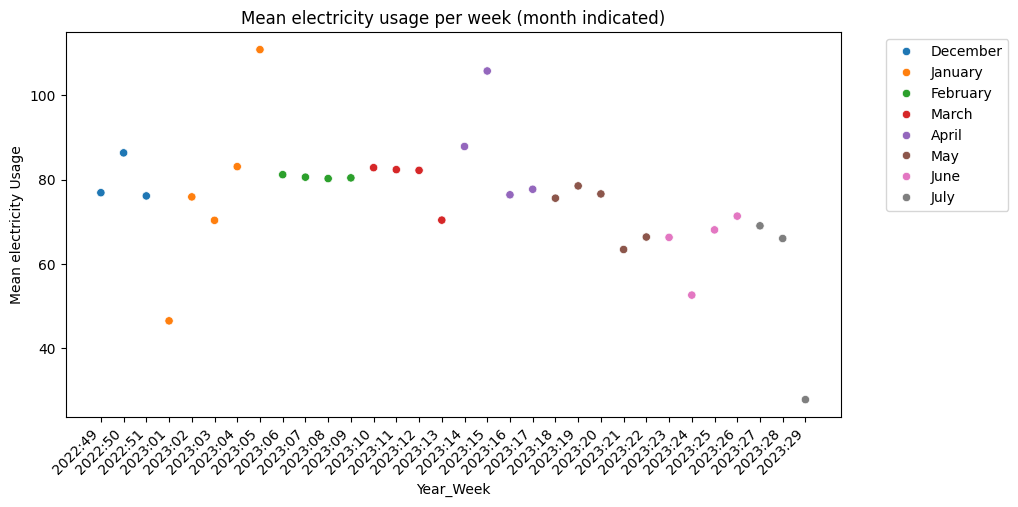

In [172]:
# Define the specific weeks you want to include
selected_weeks = [f'2022:{i:02d}' for i in range(49, 52)] + [f'2023:{i:02d}' for i in range(1, 30)]
# Filter the DataFrame to include only the selected weeks
p1e_plot_selected = p1e_plot2[p1e_plot2['Year_Week'].isin(selected_weeks)]
# Plot the mean electricity usage per week
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Mean electricity usage per week (month indicated)")
sb.scatterplot(p1e_plot_selected, x='Year_Week', y='Totalelectricity_y', hue='MonthName', ax=ax, palette='tab10')
plt.xticks(rotation=45, ha='right')
ax.set_ylabel('Mean electricity Usage')
# Get handles and labels for legend
handles, labels = plt.gca().get_legend_handles_labels()
# Add legend to plot
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Comments on P1e Visualization 1

The graphic above shows that there are fluctuations in the mean electricity usage between week 51 in 2022 and week 27 in 2023. This visualization allows us to observe that January has both the highest and lowest electricity usage which is 48kwh and 118kwh respectively. However this does not provide us with a complete picture of the fluctuations. The average amount of electricity used appears to range from 78 to 98 starting in December, with a significant decline observed in the first week of January. The next week of January saw yet another significant rise. Between that week and the final week of March, the average amount of electricity used stabilized.Furthermore, the average electricity demand increases during the first two weeks of April once more, but then decreases until the first week of July. These findings make sense because wintertime often sees higher electricity usage due to colder temperatures than summertime ones.

## P1e visualization 2
We then decided to check also if  there are fluctuations of the mean electricity usage across the different days of the week for every month.

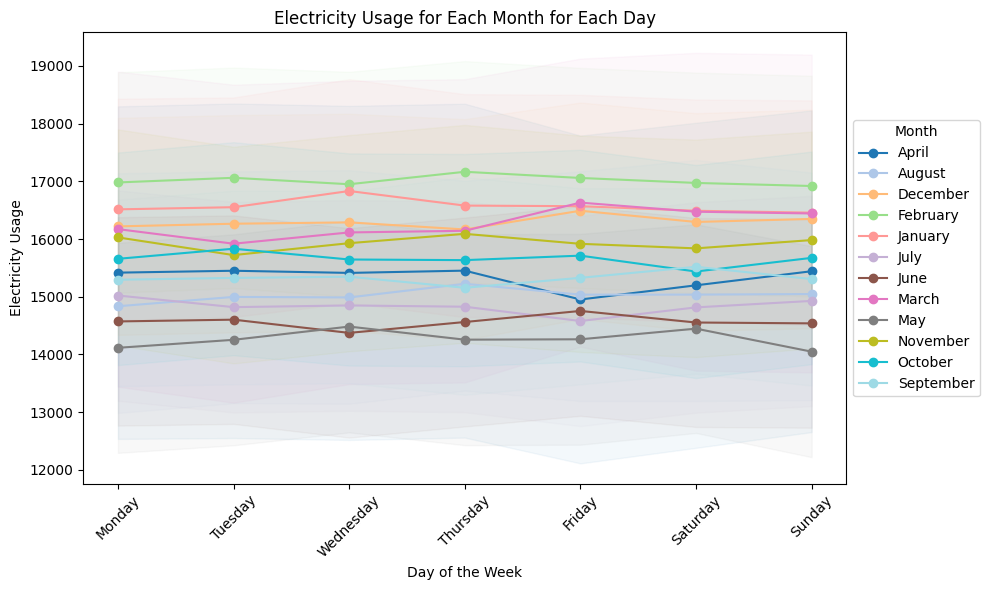

In [160]:
# Group by 'Month_Name' and 'day', and calculate the mean and standard deviation of 'Totalelectricity' for each group
grouped = df.groupby(['Month_Name', 'day'])['Totalelectricity'].agg(['mean', 'std']).reset_index()
months = grouped['Month_Name'].unique()

colors = plt.cm.tab20(np.linspace(0, 1, len(months)))
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over unique months, assign color, and plot each month separately
for month, color in zip(months, colors):
    month_data = grouped[grouped['Month_Name'] == month]
    ax.plot(month_data['day'], month_data['mean'], marker='o', label=month, color=color)
    ax.fill_between(month_data['day'], month_data['mean'] - month_data['std'], month_data['mean'] + month_data['std'], color=color, alpha=0.05)  

# Add legend on the left side and titles
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Electricity Usage')
ax.set_title('Electricity Usage for Each Month for Each Day')
ax.legend(title='Month', loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Comments on P1e Visualization 2


The plot above shows that, even within the same months, there are variations in the average amount of power used on different days of the week. That graphic makes it clear that, compared to the other months, practically all daily electricity usage is lower in May. On the other hand, the highest daily mean electricity use occurs in December, January, and February, with February topping the list. All things considered, we can state that certain months, like October, July, and March, exhibit fluctuations in daily consumption and do not conform to any particular pattern.
We can also use these graphs to make additional observations about the patterns that exist between the days of the week. For instance, we can observe that, depending on the month, different days have higher electricity usage. It's Thursday for February and November and Wednesday for May and January.
Furthermore, it is noticeable that certain months, including December, April, and September, appear stable during the first three days of the week.
Thus, a general conclusion would be that electricity usage is lower in the late spring and early summer months of May and June, and greater in the winter months of December, January, and February. Given that demand is higher in the winter than it is in the spring, this makes sense. Furthermore, as there are several fluctuations for eacseveral months and there is no pattern in the consumption of energy, we are unable to draw any conclusions about the consumption on a daily basis.

## P1g: Total Gas Used

Again we performed data manipulation. The new data set has 122 rows and 4 columns. It consists of the following columns:

- time: Date of each observation
- DailGasDifference : Daily gas usage.
- MonthName: Name of month of the measurement.

In [6]:
df_gas = df_p1g.copy()
df_gas = df_gas.dropna(subset=['total_gas_used'])
# convert the 'time' column to datetime format
df_gas['time'] = pd.to_datetime(df_gas['time'])
# select the columns columns 'datetime' and 'total_gas_used'; set 'datetime' as the index
df_target = df_gas[['time', 'total_gas_used']]
df_target.set_index('time', inplace=True)
# find the first and last recorded gas usage of each day, calculate the difference
df_first = df_target.resample('D').first()
df_last = df_target.resample('D').last()
df_last_shifted = df_last.shift(-1)
df_daily_diff = df_last_shifted['total_gas_used'] - df_first['total_gas_used']
# remove NAs, reset the index, rename the columns
df_daily_diff = df_daily_diff.dropna()
df_daily_diff = df_daily_diff.reset_index()
df_daily_diff.rename(columns={'total_gas_used': 'DailyGasDifference'}, inplace=True)
# Add a column for month
df_daily_diff['Month'] = df_daily_diff['time'].dt.month
# Add month name
df_daily_diff['MonthName'] = df_daily_diff['Month'].replace({1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May',6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October',11: 'November', 12: 'December'
})
# Define the correct month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_daily_diff['MonthName'] = pd.Categorical(df_daily_diff['MonthName'], categories=month_order, ordered=True)
df2 = df_daily_diff.groupby('time').agg({'DailyGasDifference': 'sum','MonthName': 'first'  # Taking the first month name in each group
}).reset_index()
#df2.head()

## P1g visualization 1
The first visualization regarding the P1g is about to check if there are any specific patterns in the total gas usage for every month of 2023.

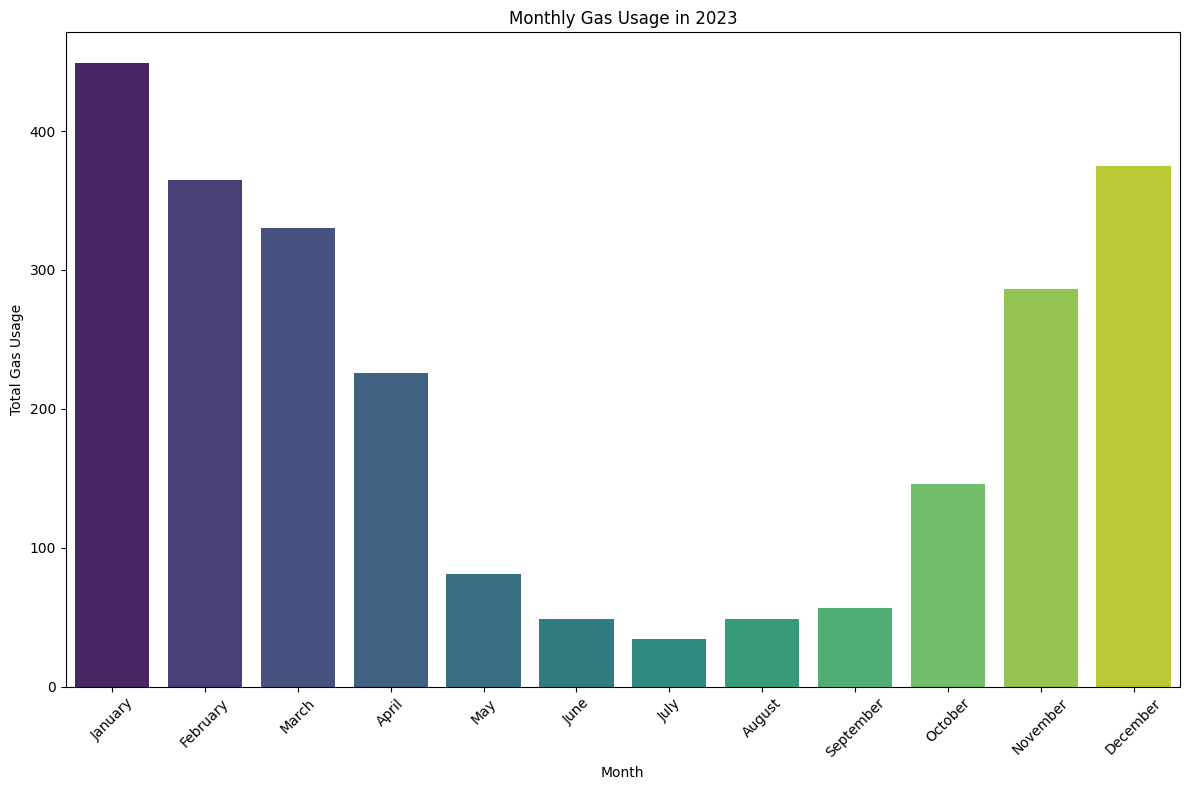

In [7]:
warnings.filterwarnings('ignore')
# Filter data for the year 2023
df2_2023 = df2[df2['time'].dt.year == 2023]
# Aggregate daily gas differences to monthly
df_monthly_gas_2023 = df2_2023.groupby(['MonthName']).agg({ 'DailyGasDifference': 'sum'}).reset_index()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_monthly_gas_2023['MonthName'] = pd.Categorical(df_monthly_gas_2023['MonthName'], categories=month_order, ordered=True)
# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(data=df_monthly_gas_2023, x='MonthName', y='DailyGasDifference', palette='viridis')
plt.title('Monthly Gas Usage in 2023')
plt.xlabel('Month')
plt.ylabel('Total Gas Usage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Comments on P1g Visualization 1

The bar chart illustrates the monthly gas usage for the year 2023. The data indicates a significant variation in gas consumption across different months, with the highest usage recorded in January at over 400 units. This is followed by a gradual decrease, with February and March showing high usage but less than January. April's usage is moderately high, whereas May shows a substantial drop. The summer months of June, July, and August have the lowest gas usage, indicating reduced dependency on gas during warmer months. Starting from September, there's a gradual increase in gas consumption, with a notable rise in October, and further substantial increases in November and December. December's usage is second only to January, likely due to colder weather necessitating more heating. Overall, the highest gas usage indicated in January while the lowest in July, with 400 and 40 total usage respectively.

## P1g visualization 2
The second visualization regarding the P1g is about to check if there are any specific patterns in the daily gas difference by day for every month of 2023.

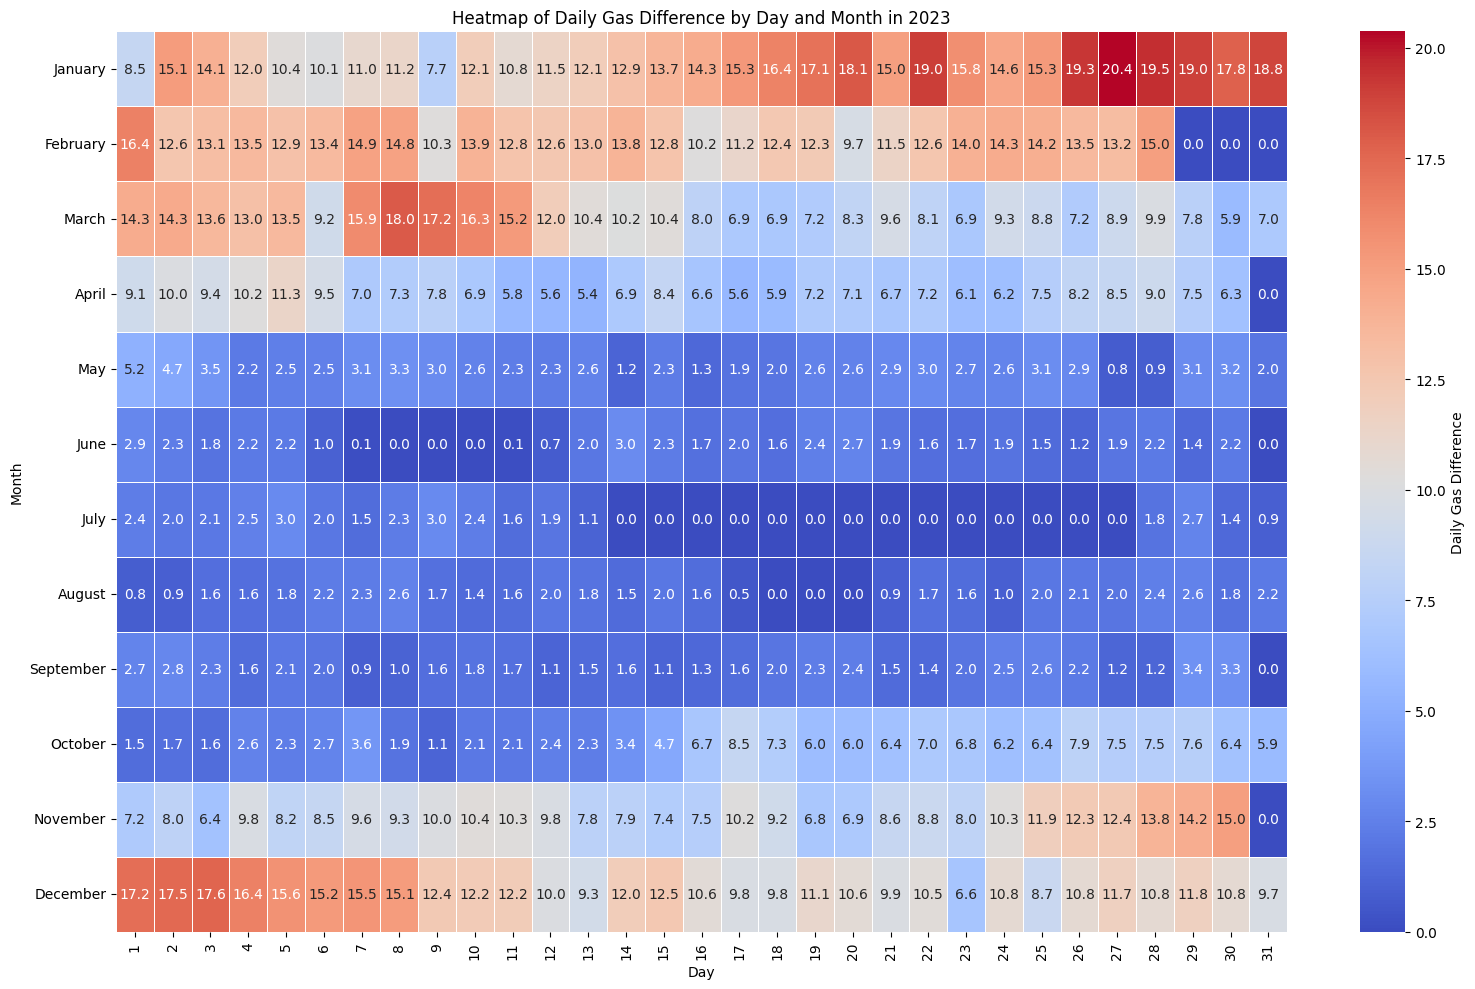

In [9]:
df2_2023['Day'] = df2_2023['time'].dt.day
pivot_table_2023 = df2_2023.pivot_table(values='DailyGasDifference', index='MonthName', columns='Day', aggfunc='sum').reindex(month_order)
plt.figure(figsize=(16, 10))
sns.heatmap(pivot_table_2023, annot=True, fmt=".1f", cmap='coolwarm', linewidths=.5, cbar_kws={'label': 'Daily Gas Difference'})
plt.title('Heatmap of Daily Gas Difference by Day and Month in 2023')
plt.xlabel('Day')
plt.ylabel('Month')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Comments on P1g Visualization 2

The heatmap illustrates the daily cloud cover recordings by day and location throughout 2023, revealing distinct seasonal and geographical patterns. The data indicates a significant variation in gas consumption across different months and days, with the highest usage recorded on January 27th at 20.4 points, while the lowest gas consumption was observed on some days in June, July, and August. Notably, February's gas consumption remained relatively stable, ranging from 9.7 to 15.0, except for February 1st, which saw a peak of 16.4. Additionally, the months of May, June, July, August, and September experienced lower gas usage, with values ranging from 0 to 5.2. Overall, the highest consumption days of 2023 were January 26th-31st and December 1st-3rd, whereas the lowest consumption days were in mid-July. These data are logical, as gas usage is typically higher during the winter months compared to the spring and summer months.


## P1g Table 

The following table summarizes the daily gas consumption across different months with key statistics including the number of observations (count), mean, minimum, maximum, and percentiles (25%, 50%, 75%), as well as standard deviation. January has the highest daily gas usage (15.03) with a notable 75th percentile value (17.90) and a standard deviation of 3.97. December shows the highest standard deviation (4.57), suggesting the most variability in daily gas usage across all months. June and September have similar means (1.80 and 1.87 respectively) and relatively lower variability. July records the lowest daily gas usage (0.69), indicating lower overall gas consumption. The data highlights both the central tendency and dispersion of daily gas usage across months, showing significant seasonal variations.

In [10]:
warnings.filterwarnings('ignore')
df2.groupby('MonthName').describe()['DailyGasDifference']
df2.groupby('MonthName').describe()['DailyGasDifference'].round(2).sort_values(by='MonthName', ascending=True)

,count,mean,min,25%,50%,75%,max,std
MonthName,,,,,,,,
January,60.0,15.03,7.68,12.05,15.04,17.90,25.85,3.97
February,57.0,11.92,2.34,11.45,12.79,13.42,16.41,2.83
March,76.0,9.23,3.92,6.92,8.11,11.08,18.02,3.43
April,80.0,6.23,0.31,3.92,6.64,8.37,12.00,2.96
May,62.0,2.22,0.35,1.72,2.23,2.85,5.20,0.94
June,60.0,1.80,0.00,1.61,1.90,2.23,3.03,0.70
July,62.0,0.69,0.00,0.00,0.00,1.30,3.02,0.95
August,62.0,1.45,0.00,1.10,1.49,1.81,2.61,0.57
September,60.0,1.87,0.69,1.40,1.68,2.24,3.40,0.65


## Conclusion

In conclusion, the data analysis provides critical information about trends in gas and electricity usage.

For electricity usage, noticeable fluctuations were observed in weekly usage, with distinct seasonal variations. The data revealed higher electricity consumption during certain months, potentially correlating with seasonal demands such as heating or cooling needs. Calculating and plotting the differences in total electricity usage allowed for a clearer identification of these trends. Electricity use varies by month, with December, January, and February having the highest mean usage, and May having the lowest. Regarding electricity consumption per day, no definitive conclusions can be drawn since the usage fluctuated throughout all months and did not follow any consistent pattern.

Similarly, the analysis for gas usage followed a parallel methodology, emphasizing the importance of understanding the usage patterns of both utilities. The visualizations and statistical analyses provided a comprehensive view of how gas consumption varies weekly and seasonally. As shown in the first plot of gas usage, the month with the highest gas usage in 2023 was January, and there was a decrease until July, which had the lowest usage. After July, an increase was observed, with December having high consumption similar to January. Regarding daily patterns, the last days of January and the first days of December showed higher consumption, while the middle months exhibited the opposite trend.

Overall, the analyses offer useful information for comprehending and controlling patterns of gas and electricity consumption. Stakeholders can improve energy use and create effective consumption strategies by taking into account daily, weekly, monthly, and yearly variations.






